# Mental Health Chatbot

## Goal


## RAG

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
import sys
print(sys.executable)
import wandb
import gradio as gr
import psycopg2
from dotenv import load_dotenv
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from rank_bm25 import BM25Okapi
from openai import OpenAI
load_dotenv()
NEON_PG_CONNECTION_URL = os.environ['NEON_PG_CONNECTION_URL']

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/bin/python


### Data Pre-Processing & Insert to DB

In [3]:
def preprocess_data():
    ds1 = load_dataset("Amod/mental_health_counseling_conversations")
    ds2 = load_dataset("mpingale/mental-health-chat-dataset")

    # Rename columns "Context": "Question", "Response": "Answer" of ds1
    ds1 = ds1.rename_column("Context", "Question")
    ds1 = ds1.rename_column("Response", "Answer")
    ds2 = ds2.remove_columns(["questionID", "questionTitle", "questionLink", "topic", "therapistInfo", "therapistURL", "upvotes", "views", "text"])
    ds2 = ds2.rename_column("questionText", "Question")
    ds2 = ds2.rename_column("answerText", "Answer")

    # Convert to pandas DataFrame
    df1 = ds1['train'].to_pandas()
    df2 = ds2['train'].to_pandas()

    # Drop duplicates & NAs
    df1 = df1.drop_duplicates(subset=["Question", "Answer"]).dropna(subset=["Question", "Answer"])
    df2 = df2.drop_duplicates(subset=["Question", "Answer"]).dropna(subset=["Question", "Answer"])

    # Combine datasets
    combined_df = pd.concat([df1, df2])

    questions = combined_df['Question'].tolist()
    answers = combined_df['Answer'].tolist()

    return questions, answers

# Connect to the database
try:
    connection = psycopg2.connect(NEON_PG_CONNECTION_URL)
    connection.autocommit = True
    print("Connected to Neon Postgres!")
except Exception as e:
    print("Cannot connect to Neon Postgres:", e)

cursor = connection.cursor()

questions, answers = preprocess_data()
# Vectorization
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
question_vectors = model.encode(questions)
cursor.execute("""
    CREATE TABLE IF NOT EXISTS mental_health_qa (
        id SERIAL PRIMARY KEY,
        question TEXT,
        answer TEXT,
        vector FLOAT8[]
    )
""")

# Insert the data into the database
for i in range(len(questions)):
    cursor.execute("""
        INSERT INTO mental_health_qa (question, answer, vector)
        VALUES (%s, %s, %s)
    """, (questions[i], answers[i], question_vectors[i].tolist()))
connection.close()

Connected to Neon Postgres!


/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Retrieval Model

In [43]:
# Function to query the database and augment responses
def query_and_augment(user_query, use_rag, temperature):
    # Connect to the database
    connection = psycopg2.connect(os.getenv('NEON_PG_CONNECTION_URL'))
    cursor = connection.cursor()

    cursor.execute("SELECT question, answer FROM mental_health_qa")
    records = cursor.fetchall()

    questions = [record[0] for record in records]
    answers = [record[1] for record in records]

    # Close the connection
    connection.close()
    
    # Implement BM25 to find the best match
    tokenized_questions = [q.split() for q in questions]
    bm25 = BM25Okapi(tokenized_questions)
    best_match_index = bm25.get_top_n(user_query.split(), questions, n=1)[0]
    
    # Print the top 5 matches for debugging
    print(bm25.get_top_n(user_query.split(), questions, n=5))
        
    best_answer = answers[questions.index(best_match_index)]

    if use_rag:
        # Generate augmented answer using the pipeline
        prompt = f"User: {user_query}\n\n\nImprove the response from the database:\n\nBot: {best_answer}\nBot (improved):"
        print(f"Prompt: {prompt}")
        
        client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an empathetic assistant. You can respond with supportive words."},
                {"role": "user", "content": "Answer the user_query based on the best answer.\n\n" + prompt},
                {"role": "assistant", "content": best_answer}
            ],
            model="gpt-4o",
            temperature=temperature,
        )
        return response.choices[0].message.content
    else:
        prompt = f"User: {user_query}"
        print(f"Prompt: {prompt}")
        
        client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an empathetic assistant. You can respond with supportive words."},
                {"role": "user", "content": prompt},
            ],
            temperature=temperature,
        )
        return response.choices[0].message.content
# answer = query_and_augment("My grandson's step-mother sends him to school with a pink Barbie backpack as a form of punishment.")
# answer = query_and_augment("I'm feeling depressed")
# print(answer)


In [44]:
# Define the Gradio interface
iface = gr.Interface(
    fn=query_and_augment,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter your query here...", label="User Query"),
        gr.Checkbox(label="Use RAG"),
        gr.Slider(minimum=0.1, maximum=1.0, value=0.7, label="Temperature")
    ],
    outputs="text",
    title="Mental Health Chatbot",
    description="A chatbot that provides empathetic responses to mental health queries."
)

# Launch the Gradio interface
iface.launch()

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


["I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a

# Fine-tuning Approach - without Emotion

## GPT2

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, EarlyStoppingCallback
import json
import torch

### Data Preparation & Model Setup

In [5]:
# Load Dataset
dataset = load_dataset('Estwld/empathetic_dialogues_llm')
dataset = dataset['train'].select(range(10000))

# Explore the data
def explore_data(dataset, tokenizer):
    num_conversations = len(dataset)
    max_length = 0
    longest_conversation = None

    for example in dataset:
        conversations = example['conversations']
        inputs = [turn['content'] for turn in conversations]
        tokenized_inputs = tokenizer(inputs, padding=False, truncation=False)
        total_length = sum(len(tokens) for tokens in tokenized_inputs['input_ids'])
        if total_length > max_length:
            max_length = total_length
            longest_conversation = conversations

    print(f"Number of conversations: {num_conversations}")
    print(f"Length of the longest conversation: {max_length} tokens")
    print("Longest conversation:", json.dumps(longest_conversation, indent=4))

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.add_special_tokens({'additional_special_tokens': ['<USER>', '<ASSISTANT>', '<PAD>']})
tokenizer.pad_token = '<PAD>'

# Explore data with token length
explore_data(dataset, tokenizer)

model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
model.resize_token_embeddings(len(tokenizer))

# Tokenize. Identify the role of the speaker. Append the role and the emotion to the beginning
# of each conversation.
def preprocess_function(examples):
    inputs = []
    labels = []
    for i in range(len(examples['conversations'])):
        conversations = examples['conversations'][i]
        emotion = examples['emotion'][i]
        for turn in conversations:
            role = '<USER>' if turn['role'] == 'user' else '<ASSISTANT>'
            input_text = f"<{emotion.upper()}> {role} {turn['content']}"
            inputs.append(input_text)
            labels.append(input_text)  # Use the same text as labels for language modeling
    tokenized_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=512)
    tokenized_inputs['labels'] = tokenized_inputs['input_ids'].copy()  # Set labels
    return tokenized_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(tokenized_datasets))
val_size = len(tokenized_datasets) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(tokenized_datasets, [train_size, val_size])

# Define training arguments with early stopping and load_best_model_at_end
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="wandb",  # Enable logging to Weights & Biases
    load_best_model_at_end=True,  # Required for EarlyStoppingCallback
    metric_for_best_model='eval_loss',  # Metric to use for early stopping
    greater_is_better=False  # Lower eval_loss is better
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback]
)

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Number of conversations: 10000
Length of the longest conversation: 472 tokens
Longest conversation: [
    {
        "content": "Life can be really not a happy place.",
        "role": "user"
    },
    {
        "content": "Sadly, I agree with you.  As I get older, it seems like that more and more.  What happened that made you feel that way?",
        "role": "assistant"
    },
    {
        "content": "Oh so many things. Lots of trauma. Life really is just full of lots of really difficult events..trying to maintain your spirit and being a good person through it, is really the task of life!",
        "role": "user"
    },
    {
        "content": "Its so true! I battle chronic illness and excruciating pain daily for almost 14 years now not to mention drowning in old medical bills.  I put my faith in God and pray for relief.  Its really hard to stay optimistic.  I really hope life improves for you and you can enjoy and embrace life again.  ",
        "role": "assistant"
    },
    {
   

### Training & Eval

In [6]:
trainer.train()

# Save and Deploy Model
model.save_pretrained('./fine_tuned_gpt2')
tokenizer.save_pretrained('./fine_tuned_gpt2')

  0%|          | 0/12864 [00:00<?, ?it/s]

{'loss': 4.2791, 'grad_norm': 26.4871768951416, 'learning_rate': 4.996113184079602e-05, 'epoch': 0.0}
{'loss': 0.5705, 'grad_norm': 9.253724098205566, 'learning_rate': 4.992226368159204e-05, 'epoch': 0.0}
{'loss': 0.3234, 'grad_norm': 1.3689318895339966, 'learning_rate': 4.988339552238806e-05, 'epoch': 0.01}
{'loss': 0.2403, 'grad_norm': 1.899427890777588, 'learning_rate': 4.984452736318408e-05, 'epoch': 0.01}
{'loss': 0.193, 'grad_norm': 0.3219219148159027, 'learning_rate': 4.980565920398011e-05, 'epoch': 0.01}
{'loss': 0.1662, 'grad_norm': 0.38007235527038574, 'learning_rate': 4.976679104477612e-05, 'epoch': 0.01}
{'loss': 0.186, 'grad_norm': 0.372415691614151, 'learning_rate': 4.972792288557214e-05, 'epoch': 0.02}
{'loss': 0.1612, 'grad_norm': 0.31438660621643066, 'learning_rate': 4.968905472636816e-05, 'epoch': 0.02}
{'loss': 0.1549, 'grad_norm': 0.40003296732902527, 'learning_rate': 4.9650186567164184e-05, 'epoch': 0.02}
{'loss': 0.1672, 'grad_norm': 0.7113328576087952, 'learning_

  0%|          | 0/1072 [00:00<?, ?it/s]

{'eval_loss': 0.11262381076812744, 'eval_runtime': 224.9282, 'eval_samples_per_second': 38.128, 'eval_steps_per_second': 4.766, 'epoch': 1.0}
{'loss': 0.1155, 'grad_norm': 0.1330685317516327, 'learning_rate': 3.3325559701492534e-05, 'epoch': 1.0}
{'loss': 0.1133, 'grad_norm': 0.13911226391792297, 'learning_rate': 3.3286691542288555e-05, 'epoch': 1.0}
{'loss': 0.104, 'grad_norm': 0.14743374288082123, 'learning_rate': 3.324782338308458e-05, 'epoch': 1.01}
{'loss': 0.1094, 'grad_norm': 0.13326968252658844, 'learning_rate': 3.32089552238806e-05, 'epoch': 1.01}
{'loss': 0.1038, 'grad_norm': 0.18125230073928833, 'learning_rate': 3.317008706467662e-05, 'epoch': 1.01}
{'loss': 0.1138, 'grad_norm': 0.1289147287607193, 'learning_rate': 3.313121890547264e-05, 'epoch': 1.01}
{'loss': 0.1105, 'grad_norm': 0.1362394243478775, 'learning_rate': 3.309235074626866e-05, 'epoch': 1.01}
{'loss': 0.1195, 'grad_norm': 0.15491220355033875, 'learning_rate': 3.305348258706468e-05, 'epoch': 1.02}
{'loss': 0.1162

  0%|          | 0/1072 [00:00<?, ?it/s]

{'eval_loss': 0.11100868135690689, 'eval_runtime': 224.7325, 'eval_samples_per_second': 38.161, 'eval_steps_per_second': 4.77, 'epoch': 2.0}
{'loss': 0.1015, 'grad_norm': 0.12430474907159805, 'learning_rate': 1.6651119402985075e-05, 'epoch': 2.0}
{'loss': 0.1104, 'grad_norm': 0.15321312844753265, 'learning_rate': 1.6612251243781096e-05, 'epoch': 2.0}
{'loss': 0.0994, 'grad_norm': 0.14088506996631622, 'learning_rate': 1.6573383084577117e-05, 'epoch': 2.01}
{'loss': 0.0951, 'grad_norm': 0.16521072387695312, 'learning_rate': 1.6534514925373135e-05, 'epoch': 2.01}
{'loss': 0.1088, 'grad_norm': 0.11917388439178467, 'learning_rate': 1.6495646766169152e-05, 'epoch': 2.01}
{'loss': 0.1193, 'grad_norm': 0.24216444790363312, 'learning_rate': 1.6456778606965177e-05, 'epoch': 2.01}
{'loss': 0.1148, 'grad_norm': 0.14327472448349, 'learning_rate': 1.6417910447761194e-05, 'epoch': 2.01}
{'loss': 0.0963, 'grad_norm': 0.13759209215641022, 'learning_rate': 1.6379042288557215e-05, 'epoch': 2.02}
{'loss':

  0%|          | 0/1072 [00:00<?, ?it/s]

{'eval_loss': 0.11077836900949478, 'eval_runtime': 224.4632, 'eval_samples_per_second': 38.207, 'eval_steps_per_second': 4.776, 'epoch': 3.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 9038.0696, 'train_samples_per_second': 11.386, 'train_steps_per_second': 1.423, 'train_loss': 0.11605956108860709, 'epoch': 3.0}


('./fine_tuned_gpt2/tokenizer_config.json',
 './fine_tuned_gpt2/special_tokens_map.json',
 './fine_tuned_gpt2/vocab.json',
 './fine_tuned_gpt2/merges.txt',
 './fine_tuned_gpt2/added_tokens.json',
 './fine_tuned_gpt2/tokenizer.json')

  0%|          | 0/1072 [00:00<?, ?it/s]

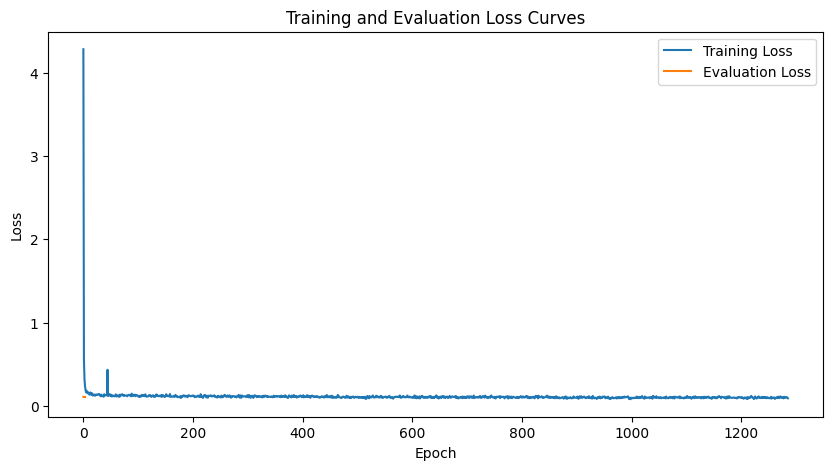

In [7]:
trainer.evaluate()
# Extract training and evaluation metrics
train_loss = trainer.state.log_history
eval_loss = [entry['eval_loss'] for entry in train_loss if 'eval_loss' in entry]
train_loss = [entry['loss'] for entry in train_loss if 'loss' in entry]

# Plot the training and evaluation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.show()

### Generate Responses
We load the base gpt2 model and the fine-tuned gpt2 model.
Gradio interface allows us to chat with either model.

In [10]:
# Load the base GPT-2 model and tokenizer
base_model_name = 'openai-community/gpt2'
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model =  AutoModelForCausalLM.from_pretrained(base_model_name)

# Load the fine-tuned GPT-2 model and tokenizer
fine_tuned_model_path = './fine_tuned_gpt2'
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path)
fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_model_path)

def generate_response(model_name, user_query):
    if model_name == 'Base gpt2':
        tokenizer = base_tokenizer
        model = base_model
        prompt = user_query  # Use a simpler prompt for the base model
    else:
        tokenizer = fine_tuned_tokenizer
        model = fine_tuned_model
        prompt = f"User: {user_query}\nAssistant:"  # Use the original prompt for the fine-tuned model

    # # Define the prompt to set the context
    # prompt = f"User: {user_query}\nAssistant:"

    # Tokenize the input
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask

    # Generate response
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=256,  # Set a reasonable max length
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        # early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Use beam search with 5 beams
        do_sample=True,  # Use sampling
        temperature=0.7,  # Control randomness
    )
    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    
    # # Optionally, truncate the response at the first stop token (e.g., newline)
    # stop_token = '\n'
    # if stop_token in response:
    #     response = response.split(stop_token)[0]
    print(response)
    return response

# Create Gradio interface
iface = gr.Interface(
    fn=generate_response,
    inputs=[
        gr.components.Dropdown(choices=['Base gpt2', 'Fine-Tuned Base gpt2'], label='Model'),
        gr.components.Textbox(lines=5, placeholder='Enter your query here...', label='User Query')
    ],
    outputs='text',
    title='Chat with GPT-2',
    description='Select a model and enter your query to chat with gpt2 or the fine-tuned gpt2 model.'
)

# Launch the interface
iface.launch()

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


## DistilGPT2

In [25]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, EarlyStoppingCallback
import json
import torch

In [79]:
# Load Dataset
dataset = load_dataset('Estwld/empathetic_dialogues_llm')
dataset = dataset['train'].select(range(10000))

# Explore the data
def explore_data(dataset, tokenizer):
    num_conversations = len(dataset)
    max_length = 0
    longest_conversation = None

    for example in dataset:
        conversations = example['conversations']
        inputs = [turn['content'] for turn in conversations]
        tokenized_inputs = tokenizer(inputs, padding=False, truncation=False)
        total_length = sum(len(tokens) for tokens in tokenized_inputs['input_ids'])
        if total_length > max_length:
            max_length = total_length
            longest_conversation = conversations

    print(f"Number of conversations: {num_conversations}")
    print(f"Length of the longest conversation: {max_length} tokens")
    print("Longest conversation:", json.dumps(longest_conversation, indent=4))

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
tokenizer.add_special_tokens({'additional_special_tokens': ['<USER>', '<ASSISTANT>', '<PAD>']})
tokenizer.pad_token = '<PAD>'

# Explore data with token length
explore_data(dataset, tokenizer)

model = AutoModelForCausalLM.from_pretrained('distilgpt2')
model.resize_token_embeddings(len(tokenizer))

# Tokenize and preprocess data
def preprocess_function(examples):
    inputs = []
    labels = []
    
    for i in range(len(examples['conversations'])):
        conversation = examples['conversations'][i]
        emotion = examples['emotion'][i]
        for j in range(len(conversation) - 1):
            if conversation[j]['role'] == 'user' and conversation[j + 1]['role'] == 'assistant':
                user_input = f"<{emotion.upper()}> <USER> {conversation[j]['content']}"
                assistant_response = f"<{emotion.upper()}> <ASSISTANT> {conversation[j + 1]['content']}"
                inputs.append(user_input)
                labels.append(assistant_response)
    tokenized_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=512)
    tokenized_labels = tokenizer(labels, padding='max_length', truncation=True, max_length=512)
    tokenized_inputs['labels'] = tokenized_labels['input_ids'].copy()  # Set labels
    return tokenized_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(tokenized_datasets))
val_size = len(tokenized_datasets) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(tokenized_datasets, [train_size, val_size])

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    learning_rate=5e-5,
    report_to='wandb',
    run_name='distilgpt2-finetuning',
    load_best_model_at_end=True,  # Required for EarlyStoppingCallback
    metric_for_best_model='eval_loss',  # Metric to use for early stopping
    greater_is_better=False  # Lower eval_loss is better
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Number of conversations: 10000
Length of the longest conversation: 472 tokens
Longest conversation: [
    {
        "content": "Life can be really not a happy place.",
        "role": "user"
    },
    {
        "content": "Sadly, I agree with you.  As I get older, it seems like that more and more.  What happened that made you feel that way?",
        "role": "assistant"
    },
    {
        "content": "Oh so many things. Lots of trauma. Life really is just full of lots of really difficult events..trying to maintain your spirit and being a good person through it, is really the task of life!",
        "role": "user"
    },
    {
        "content": "Its so true! I battle chronic illness and excruciating pain daily for almost 14 years now not to mention drowning in old medical bills.  I put my faith in God and pray for relief.  Its really hard to stay optimistic.  I really hope life improves for you and you can enjoy and embrace life again.  ",
        "role": "assistant"
    },
    {
   

### Training & Eval

In [85]:
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('./fine_tuned_distilgpt2')
tokenizer.save_pretrained('./fine_tuned_distilgpt2')

  0%|          | 0/6159 [00:00<?, ?it/s]

I'm feeling down a little bit, but I don't know if I'll be able to get back to work. I'm trying to figure out what's going on."
I'm feeling down a little bit, but I'm still feeling pretty good. It's been a long time since I've been here, and I still have a lot of work to do, so I'll just have to wait and see what happens."
{'loss': 0.2018, 'grad_norm': 0.3387247622013092, 'learning_rate': 4.594089949667154e-05, 'epoch': 0.24}
{'loss': 0.2018, 'grad_norm': 0.175648033618927, 'learning_rate': 4.188179899334308e-05, 'epoch': 0.49}


KeyboardInterrupt: 

### Evaluate

  0%|          | 0/514 [00:00<?, ?it/s]

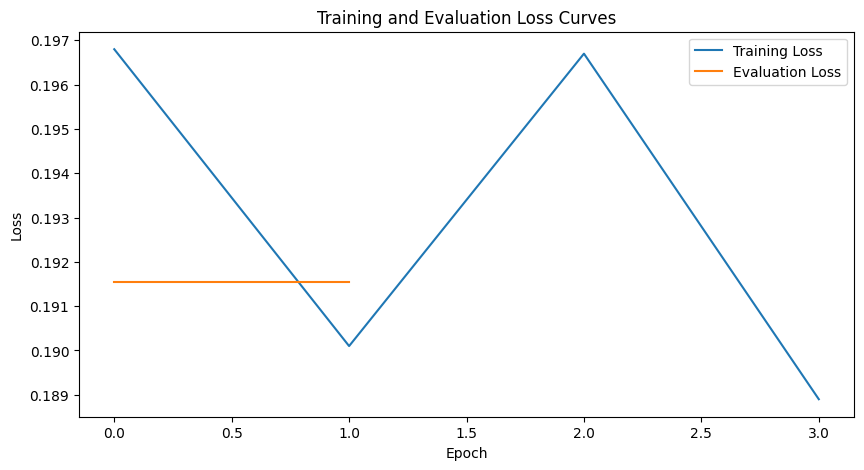

In [71]:
import matplotlib.pyplot as plt

# Evaluate the model
trainer.evaluate()

# Extract training and evaluation metrics
train_loss = trainer.state.log_history
eval_loss = [entry['eval_loss'] for entry in train_loss if 'eval_loss' in entry]
train_loss = [entry['loss'] for entry in train_loss if 'loss' in entry]

# Plot the training and evaluation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.show()

### Generate Responses

In [84]:
# Load the base GPT-2 model and tokenizer
base_model_name = 'distilgpt2'
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model =  AutoModelForCausalLM.from_pretrained(base_model_name)

# Load the fine-tuned GPT-2 model and tokenizer
fine_tuned_model_path = './fine_tuned_distilgpt2'
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path)
fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_model_path)

def generate_response(model_name, user_query):
    if model_name == 'Base distilgpt2':
        tokenizer = base_tokenizer
        model = base_model
        prompt = user_query  # Use a simpler prompt for the base model
    else:
        tokenizer = fine_tuned_tokenizer
        model = fine_tuned_model
        prompt = f"User: {user_query}\nAssistant:"  # Use the original prompt for the fine-tuned model

    # # Define the prompt to set the context
    # prompt = f"User: {user_query}\nAssistant:"

    # Tokenize the input
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask

    # Generate response
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=256,  # Set a reasonable max length
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        # early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Use beam search with 5 beams
        do_sample=True,  # Use sampling
        temperature=0.7,  # Control randomness
    )
    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    
    # # Optionally, truncate the response at the first stop token (e.g., newline)
    # stop_token = '\n'
    # if stop_token in response:
    #     response = response.split(stop_token)[0]
    print(response)
    return response

# Create Gradio interface
iface = gr.Interface(
    fn=generate_response,
    inputs=[
        gr.components.Dropdown(choices=['Base distilgpt2', 'Fine-Tuned Base distilgpt2'], label='Model'),
        gr.components.Textbox(lines=5, placeholder='Enter your query here...', label='User Query')
    ],
    outputs='text',
    title='Chat with DistilGPT-2',
    description='Select a model and enter your query to chat with distilgpt2 or the fine-tuned distilgpt2 model.'
)

# Launch the interface
iface.launch()

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running on local URL:  http://127.0.0.1:7883

To create a public link, set `share=True` in `launch()`.


## Prompt Engineering

### Imports

In [32]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import gradio as gr
from huggingface_hub import login
import os
from dotenv import load_dotenv
load_dotenv(os.path.expanduser('~/.env'))

True

In [33]:
# Log in to Huggingface
access_token = os.getenv('HF_TOKEN')
login(token=access_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/hubert_1/.cache/huggingface/token
Login successful


### Model Setup

In [34]:
# Initialize the model and tokenizer
checkpoint = "EleutherAI/gpt-neo-2.7B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint)

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
# Set the environment variable to enable CPU fallback for MPS
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

prompt_template = """
You are an empathetic mental health coach. Your goal is to support the user by understanding their emotions and responding with empathy and care.
Do not provide medical advice. If the user expresses any thoughts of self-harm, suicide, or harming others, respond by encouraging them to contact a medical professional or emergency services immediately.
Keep your response under 120 tokens.

User Input: "{user_input}"
Response:
"""
conversation_history = ""

# Ensure the model is on the MPS device
device = torch.device("mps")
model.to(device)

def generate_response(user_input):
    # Format the prompt with the user's input
    prompt = prompt_template.format(user_input=user_input)
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # Generate the model's response
    outputs = model.generate(
        **inputs,
        max_length=120,
        pad_token_id=tokenizer.eos_token_id
    )
    # Decode the response and return it
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

def continue_conversation(user_input):
    global conversation_history
    conversation_history += f"User: {user_input}\n"
    response = generate_response(user_input)
    conversation_history += f"Coach: {response}\n"
    return response

# Define a gradio interface with input and response fields, and a field to select whether the prompt template is used.
iface = gr.Interface(
    fn=continue_conversation,
    inputs="text",
    outputs="text",
    title="Mental Health Coach Chatbot",
    description="Chat with an empathetic mental health coach. Share your thoughts and feelings to receive support and empathy.",
)

# Launch the interface
iface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


["I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a month right away. I love my husband, but I am struggling with this.", "I'm feeling rejected and frustrated. This is not new. The first month we were together, sex was about every day. Then it slowed down to once a

Traceback (most recent call last):
  File "/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/gradio/route_utils.py", line 321, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/gradio/blocks.py", line 1935, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/gradio/blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type